In [175]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
import statsmodels.api as sm
from scipy.stats import binomtest

In [181]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_same_day' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='multicategory_working_memory'
experiment_name='experiment 3'
batch_name='batch 3'
qualification_method='loose'
qualification_name_for_entire_experiment='UPDATE-completed working memory test'


PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 /Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 3/collected data/pilot_same_day/batch 3


In [182]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 

        criterions_df['binom_single_layer']=0.7
        criterions_df['binom_averages']=0.65
        criterions_df['rating_varience_test'] = 1
        
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=5
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 
        criterions_df['binom_single_layer']=0.666
        criterions_df['binom_averages']=0.6166
        criterions_df['rating_varience_test'] = 0.5
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [179]:
criterions_df=set_criterions(qualification_method)
criterions_df

longest_allowed_consequtive_strike    15.0000
fast_threshold                         0.3000
demo_accuracy_treshold                 0.0000
fast_allowed_count                     5.0000
slow_threshold                        10.0000
slow_allowed_count                     5.0000
binom_single_layer                     0.6660
binom_averages                         0.6166
rating_varience_test                   0.5000
dtype: float64

In [183]:
AMAZON_WORKER_fILE_PATH= PATH_TO_BATCH / path.Path(batch_name.capitalize().replace(' ','_')+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  60
number of participant files (of sufficient size) in the downloaded results batch: 59
number of unique participant names in the batch: 59

after removing duplicate files, number of valid participant files = 59

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A1MUQBHTMVZ8DY
invalid A2DPC8XAW7ENCG
invalid A1F7WUQ3B7Z69U
invalid AGG5IUCZA9LV4
invalid A3CC8XFM3FQ2Y6
invalid A277O0KFS99IFY
invalid A2O7W5G0T5R37T
invalid A1U48QH2ZRZP0I
invalid A1X9BOM49BHNGQ
invalid A1SARRYNMZDVXB
number of valid participants to go to further processing is: 50


In [142]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [143]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_test_key_resp.rt' in cur_sub.columns):
        cur_sub['demo_test_key_resp.rt']=np.nan
    demo_columns=['demo_loops.thisTrialN','target','image1','image2','correct','demo_test_key_resp.rt','demo_test_key_resp.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)
    sub_demo_information = sub_demo_information.dropna()

    demo_df= sub_demo_information

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    df_accuracy = cur_sub.iloc[3:63].dropna(axis=1,how='all')
    df_rating = cur_sub.iloc[63:123].dropna(axis=1,how='all')

    cols = ['workID', 'Age', 'Gender','target', 'image1', 'image2', 'correct', 'background_0', 'background_1', 'background_2', 'background_3', 'background_4', 'background_5', 'target_index','test_key_resp.keys','test_key_resp.rt','distractor_level','category','selected_dist' ]
    df_accuracy = df_accuracy[cols].reset_index(drop=True)
    df_rating = df_rating[['slider_part2.response','slider_part2.rt']].reset_index(drop=True)
    df_rating_and_accuarcy = pd.concat([df_accuracy,df_rating],axis=1)


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['rating_and_accuracy']=df_rating_and_accuarcy

    return subject_dictionary



In [144]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_rating_and_accuracy_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    #print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    #extract just the worker id as the subject name
    subject_name=subject_name.split('_')[0]
    curr_demo_df['subject']=subject_name

    curr_rating_and_accuracy_df=curr_subject_dictionary['rating_and_accuracy']
    curr_rating_and_accuracy_df['subject']=subject_name

    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_rating_and_accuracy_df=pd.concat([all_subjects_rating_and_accuracy_df,curr_rating_and_accuracy_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)

all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_rating_and_accuracy_df.to_csv(PATH_TO_BATCH / 'all_subjects_rating_and_accuracy_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [145]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(set(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',set(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 32.38, range: [25 - 63], 0.28% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [146]:
all_subjects_demo_df.head(5)

,demo_loops.thisTrialN,target,image1,image2,correct,demo_test_key_resp.rt,demo_test_key_resp.keys,subject
0,0.0,flower1.jpg,flower1.jpg,flower1_pair.jpg,left,2.7718,left,ASZIU9BR1ALX4
1,1.0,leaf2.jpg,leaf1.jpg,leaf2.jpg,right,1.2469,right,ASZIU9BR1ALX4
2,2.0,fence1.jpg,fence1.jpg,fence2.jpg,left,2.2535,left,ASZIU9BR1ALX4
3,0.0,flower1.jpg,flower1.jpg,flower1_pair.jpg,left,2.0669,left,AVK8FE2J4KJ9U
4,1.0,leaf2.jpg,leaf1.jpg,leaf2.jpg,right,0.0981,left,AVK8FE2J4KJ9U


In [147]:
all_subjects_rating_and_accuracy_df.head(5)

,workID,Age,Gender,target,image1,image2,correct,background_0,background_1,background_2,...,background_5,target_index,test_key_resp.keys,test_key_resp.rt,distractor_level,category,selected_dist,slider_part2.response,slider_part2.rt,subject
0,ASZIU9BR1ALX4,30,male,golf_course_331.jpg,golf_course_114.jpg,golf_course_331.jpg,right,golf_course_331.jpg,highway_244.jpg,mountain_107.jpg,...,bridge_169.jpg,0.0,left,0.7709,0.0,golf,golf_course_114.jpg,6.979167,2.9758,ASZIU9BR1ALX4
1,ASZIU9BR1ALX4,30,male,highway_394.jpg,highway_394.jpg,highway_406.jpg,left,mountain_160.jpg,highway_394.jpg,badlands_31.jpg,...,golf_course_166.jpg,1.0,right,1.3452,1.0,highway,highway_406.jpg,8.000000,2.1452,ASZIU9BR1ALX4
2,ASZIU9BR1ALX4,30,male,mountain_110.jpg,mountain_157.jpg,mountain_110.jpg,right,highway_37.jpg,mountain_110.jpg,playground_25.jpg,...,badlands_210.jpg,1.0,left,2.6403,0.0,mountain,mountain_157.jpg,8.968750,2.3890,ASZIU9BR1ALX4
3,ASZIU9BR1ALX4,30,male,mountain_154.jpg,mountain_154.jpg,mountain_131.jpg,left,mountain_154.jpg,playground_66.jpg,badlands_58.jpg,...,golf_course_1.jpg,0.0,right,0.9865,0.0,mountain,mountain_131.jpg,4.010417,2.8346,ASZIU9BR1ALX4
4,ASZIU9BR1ALX4,30,male,highway_294.jpg,highway_203.jpg,highway_294.jpg,right,mountain_202.jpg,highway_294.jpg,golf_course_33.jpg,...,badlands_166.jpg,1.0,left,1.3683,0.0,highway,highway_203.jpg,5.010417,2.1070,ASZIU9BR1ALX4


In [148]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))
all_subjects_demo_df['correct_bool'] = all_subjects_demo_df['correct'] == all_subjects_demo_df['demo_test_key_resp.keys'] 

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    

    #get the correctness of the demo testing phase: 
    accuracy=cur_sub_demo_encoding['correct_bool'].mean()
    mean_rt=cur_sub_demo_encoding['demo_test_key_resp.rt'].mean()

    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_demo_accuracy,demo_RT_overall_mean
ASZIU9BR1ALX4,1.000000,2.090733
AVK8FE2J4KJ9U,0.666667,1.411333
A1NOS2SUAJVMTC,0.000000,2.535667
A2LIQCD7W2VDE8,0.000000,304.895700
A3NT8QEXFBYGF,1.000000,1.186933


In [149]:
#this part extract summary information from the experiment accuracy and rating for test
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_rating_and_accuracy_df['subject'].unique()))
all_subjects_rating_and_accuracy_df['correct_bool'] = all_subjects_rating_and_accuracy_df['correct'] == all_subjects_rating_and_accuracy_df['test_key_resp.keys']

one_liners=[]
one_liners_min_binom_per=[]
for cur_subject in all_subjects_rating_and_accuracy_df['subject'].unique():
    cur_sub_rating_and_acc=all_subjects_rating_and_accuracy_df.loc[all_subjects_rating_and_accuracy_df['subject']==cur_subject]

    #remove all trials that exceed the RT threshold (which renders them as non working memory trials, but more similar to long term memory)
    cur_sub_rating_and_acc=cur_sub_rating_and_acc.query('`test_key_resp.rt`<=@criterions_df["slow_threshold"]')
    n_tries=cur_sub_rating_and_acc['distractor_level'].value_counts().values
    n_tries=np.append(n_tries,n_tries.sum())
    if type=='loose':
        alpha = 0.1 # Significance level
    else:
        alpha = 0.05

  
    # Find the value that will be significant at alpha
    vals=[]
    for cur_n in n_tries: 
        value = int(cur_n/2)

        while binomtest(value, cur_n, 0.5).pvalue > alpha:
            value += 1
        else: 
            vals.append(value)

    
    temp_df=pd.DataFrame(vals/n_tries).T
    temp_df.columns=['level_0_min_n','level_1_min_n','both_min_n']
    temp_df['subject']=cur_subject
    one_liners_min_binom_per.append(temp_df)





    rating_var = cur_sub_rating_and_acc['slider_part2.response'].std()
    rating_mean = cur_sub_rating_and_acc['slider_part2.response'].mean()
    accuracy_var = cur_sub_rating_and_acc['correct_bool'].std()
    accuracy_mean = cur_sub_rating_and_acc['correct_bool'].mean()
    mean_rt=cur_sub_rating_and_acc['test_key_resp.rt'].mean()



   #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_rating_and_acc['test_key_resp.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)
    grouped = cur_sub_rating_and_acc.groupby('distractor_level').aggregate({'slider_part2.response':'mean','correct_bool':'mean','test_key_resp.rt':'mean'})
    one_line=pd.DataFrame(index=[cur_subject])
    one_line[['level_1_rating','level_1_accuracy','level_1_rt']]=grouped.iloc[0]
    one_line[['level_3_rating','level_3_accuracy','level_3_rt']]=grouped.iloc[1]
    one_line['subject']=cur_subject
    one_line['longest_response_strike']=max_iter
    #update the summary info row: 
    one_line['Test_overall_accuracy']=accuracy_mean
    one_line['RT_overall_mean']=mean_rt
    one_line['rating_varience']=rating_var
    one_line['rating_mean']=rating_mean
    one_liners.append(one_line)

all_subjects_summary_rating_and_acc_info=pd.concat(one_liners,axis=0)
binom_criterion_df=pd.concat(one_liners_min_binom_per)
all_subjects_summary_rating_and_acc_info

,level_1_rating,level_1_accuracy,level_1_rt,level_3_rating,level_3_accuracy,level_3_rt,subject,longest_response_strike,Test_overall_accuracy,RT_overall_mean,rating_varience,rating_mean
ASZIU9BR1ALX4,6.854514,0.466667,2.727070,7.176312,0.666667,3.188552,ASZIU9BR1ALX4,50,0.561404,2.945667,1.257364,7.006944
AVK8FE2J4KJ9U,5.107917,0.520000,3.060868,5.046474,0.461538,2.770335,AVK8FE2J4KJ9U,9,0.490196,2.912753,2.268222,5.076593
A1NOS2SUAJVMTC,7.401042,0.500000,2.087233,7.412660,0.346154,2.759269,A1NOS2SUAJVMTC,2,0.428571,2.399250,1.110771,7.406436
A2LIQCD7W2VDE8,5.290133,0.633333,1.427063,4.862290,0.586207,2.055728,A2LIQCD7W2VDE8,3,0.610169,1.736068,2.249891,5.079837
A3NT8QEXFBYGF,7.673195,0.620690,1.304290,7.675265,0.448276,1.623121,A3NT8QEXFBYGF,13,0.534483,1.463705,0.472087,7.674230
A2D009L2PJ6641,7.940733,0.655172,1.579917,8.147270,0.655172,1.785055,A2D009L2PJ6641,4,0.655172,1.682486,0.758405,8.044001
A27B8SXCOOF807,7.364535,0.620690,1.495372,7.309092,0.655172,1.831324,A27B8SXCOOF807,7,0.637931,1.663348,0.662931,7.336814
A3HOPYBWSR1TWR,2.856944,0.700000,2.993200,4.810704,0.620690,2.824897,A3HOPYBWSR1TWR,3,0.661017,2.910475,1.796676,3.817267
AC7CDW53I98JT,7.385069,0.466667,2.598133,7.364236,0.633333,2.317033,AC7CDW53I98JT,3,0.550000,2.457583,0.943745,7.374653
A10NKDFS29XEBT,5.671474,0.576923,3.633150,4.655878,0.392857,3.326389,A10NKDFS29XEBT,6,0.481481,3.474089,2.227674,5.144869


In [150]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2,col_name='test_key_resp.rt'):
    isfast_outlier=(sub_test_dataframe[col_name]<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe[col_name]>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [ ]:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_rating_and_acc_info],axis=1)

In [152]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_rating_and_acc_info],axis=1)

#see if the participant convinces us that they perform above chance level accoarding to the amount of elligable trials: 
a=data_df_for_analysis['level_1_accuracy'].values>=binom_criterion_df['level_0_min_n'].values
b=data_df_for_analysis['level_3_accuracy'].values>=binom_criterion_df['level_1_min_n'].values
c=data_df_for_analysis['Test_overall_accuracy'].values>=binom_criterion_df['both_min_n'].values

binom_crit_df=pd.DataFrame([a,b,c]).T
binom_crit_df.sum(axis=1)>0
binom_crit_df['qualified_binom']=binom_crit_df.sum(axis=1)>0
binom_crit_df.index=data_df_for_analysis.index


#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

# remove patients with a rating varience that is very low - didnt rate acuratly. 
test_criterion_rating_var = data_df_for_analysis['rating_varience']>criterions_df['rating_varience_test']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    cur_sub_rating_and_acc=all_subjects_rating_and_accuracy_df.loc[all_subjects_rating_and_accuracy_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(cur_sub_rating_and_acc,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'did not reach the minimum correct trials per condition or overall (resulting in a significant binom test) {binom_crit_df["qualified_binom"].sum()}')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & test_criterions_strike & too_fast_criterions & too_slow_criterions  &  binom_crit_df['qualified_binom']
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')


summary for criterions:
did not reach the minimum correct trials per condition or overall (resulting in a significant binom test) 13
demo accuracy higher than 0.0 - qualified: 50
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 44
test too fast (thresold: 0.3, allowed count: 5.0 qualified: 41
test too slow (thresold: 10.0, allowed count: 5.0 qualified: 40
OVERALL: number of qualified participants (adhere to all criterions): 12


In [153]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
disqualification_df=pd.concat([demo_criterions_accuracy,test_criterions_strike,tooslow_df,toofast_df,binom_crit_df],axis=1)
disqualification_df.head(50)


,demo_demo_accuracy,longest_response_strike,not_too_slow,not_too_Fast,0,1,2,qualified_binom
ASZIU9BR1ALX4,True,False,True,True,False,False,False,False
AVK8FE2J4KJ9U,True,True,False,True,False,False,False,False
A1NOS2SUAJVMTC,True,True,True,False,False,False,False,False
A2LIQCD7W2VDE8,True,True,True,True,False,False,False,False
A3NT8QEXFBYGF,True,True,True,False,False,False,False,False
A2D009L2PJ6641,True,True,True,True,False,False,True,True
A27B8SXCOOF807,True,True,True,False,False,False,True,True
A3HOPYBWSR1TWR,True,True,True,True,True,False,True,True
AC7CDW53I98JT,True,True,True,True,False,False,False,False
A10NKDFS29XEBT,True,True,False,True,False,False,False,False


In [154]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
batch_workers_df_extended[qualification_name_for_entire_experiment]=1

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_for_upload.csv'))


In [155]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]

,demo_demo_accuracy,demo_RT_overall_mean,level_1_rating,level_1_accuracy,level_1_rt,level_3_rating,level_3_accuracy,level_3_rt,subject,longest_response_strike,Test_overall_accuracy,RT_overall_mean,rating_varience,rating_mean
A2D009L2PJ6641,1.000000,1.389333,7.940733,0.655172,1.579917,8.147270,0.655172,1.785055,A2D009L2PJ6641,4,0.655172,1.682486,0.758405,8.044001
A3HOPYBWSR1TWR,0.333333,14.418667,2.856944,0.700000,2.993200,4.810704,0.620690,2.824897,A3HOPYBWSR1TWR,3,0.661017,2.910475,1.796676,3.817267
A17ERTCKB0SN24,0.333333,1.464467,7.560704,0.758621,1.475766,8.179861,0.733333,1.348567,A17ERTCKB0SN24,4,0.745763,1.411088,0.835113,7.875530
AKBDLLKJCG680,0.666667,13.994500,5.450790,0.689655,1.931834,5.485119,0.678571,1.943750,AKBDLLKJCG680,3,0.684211,1.937688,1.299609,5.467654
A2AXPB2Y8VZ3MT,0.333333,5.056867,5.553512,0.689655,2.325852,5.711605,0.666667,2.269130,A2AXPB2Y8VZ3MT,6,0.677966,2.297010,1.881653,5.633898
A2JEPT85S2FRRN,1.000000,6.505667,7.250372,0.714286,1.818861,8.039931,0.700000,1.767067,A2JEPT85S2FRRN,4,0.706897,1.792071,1.061981,7.658764
A2QZYT2MINCCSC,1.000000,7.012633,5.463362,0.724138,1.627017,6.552083,0.666667,1.764670,A2QZYT2MINCCSC,4,0.694915,1.697010,2.075482,6.016949
A31YCOB92SLSHL,1.000000,1.980033,5.877531,0.666667,2.087893,6.469136,0.633333,1.710500,A31YCOB92SLSHL,6,0.650000,1.899197,1.963330,6.173334
AOGUVIIJIXYO3,0.666667,2.105800,6.070384,0.733333,2.548273,6.717323,0.785714,2.556571,AOGUVIIJIXYO3,4,0.758621,2.552279,1.545284,6.382699
A11246G6L1GMQB,0.666667,16.664667,4.372113,0.655172,2.628224,5.196213,0.766667,2.033720,A11246G6L1GMQB,6,0.711864,2.325934,2.075028,4.791147


In [156]:
all_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
#make sure all indexes are only the worker ID without added date and time info
newindexes=[fullname.split('_')[0] for fullname in all_data.index]
all_data.index=newindexes
all_data.head()

,demo_demo_accuracy,demo_RT_overall_mean,level_1_rating,level_1_accuracy,level_1_rt,level_3_rating,level_3_accuracy,level_3_rt,subject,longest_response_strike,...,rating_mean,demo_demo_accuracy,longest_response_strike,not_too_slow,not_too_Fast,0,1,2,qualified_binom,WorkerId
ASZIU9BR1ALX4,1.000000,2.090733,6.854514,0.466667,2.727070,7.176312,0.666667,3.188552,ASZIU9BR1ALX4,50,...,7.006944,True,False,True,True,False,False,False,False,ASZIU9BR1ALX4
AVK8FE2J4KJ9U,0.666667,1.411333,5.107917,0.520000,3.060868,5.046474,0.461538,2.770335,AVK8FE2J4KJ9U,9,...,5.076593,True,True,False,True,False,False,False,False,AVK8FE2J4KJ9U
A1NOS2SUAJVMTC,0.000000,2.535667,7.401042,0.500000,2.087233,7.412660,0.346154,2.759269,A1NOS2SUAJVMTC,2,...,7.406436,True,True,True,False,False,False,False,False,A1NOS2SUAJVMTC
A2LIQCD7W2VDE8,0.000000,304.895700,5.290133,0.633333,1.427063,4.862290,0.586207,2.055728,A2LIQCD7W2VDE8,3,...,5.079837,True,True,True,True,False,False,False,False,A2LIQCD7W2VDE8
A3NT8QEXFBYGF,1.000000,1.186933,7.673195,0.620690,1.304290,7.675265,0.448276,1.623121,A3NT8QEXFBYGF,13,...,7.674230,True,True,True,False,False,False,False,False,A3NT8QEXFBYGF


In [157]:
#make sure the index is just the worker id of each subject
newindexes=[fullname.split('_')[0] for fullname in final_participants_df.index]

final_participants_df.index=newindexes
final_participants_df.head(5)


,demo_demo_accuracy,demo_RT_overall_mean,level_1_rating,level_1_accuracy,level_1_rt,level_3_rating,level_3_accuracy,level_3_rt,subject,longest_response_strike,Test_overall_accuracy,RT_overall_mean,rating_varience,rating_mean
A2D009L2PJ6641,1.000000,1.389333,7.940733,0.655172,1.579917,8.147270,0.655172,1.785055,A2D009L2PJ6641,4,0.655172,1.682486,0.758405,8.044001
A3HOPYBWSR1TWR,0.333333,14.418667,2.856944,0.700000,2.993200,4.810704,0.620690,2.824897,A3HOPYBWSR1TWR,3,0.661017,2.910475,1.796676,3.817267
A17ERTCKB0SN24,0.333333,1.464467,7.560704,0.758621,1.475766,8.179861,0.733333,1.348567,A17ERTCKB0SN24,4,0.745763,1.411088,0.835113,7.875530
AKBDLLKJCG680,0.666667,13.994500,5.450790,0.689655,1.931834,5.485119,0.678571,1.943750,AKBDLLKJCG680,3,0.684211,1.937688,1.299609,5.467654
A2AXPB2Y8VZ3MT,0.333333,5.056867,5.553512,0.689655,2.325852,5.711605,0.666667,2.269130,A2AXPB2Y8VZ3MT,6,0.677966,2.297010,1.881653,5.633898


In [158]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_valid_subjects_only_' + qualification_method + '.csv'))
all_data.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_all_subject_' + qualification_method + '.csv'))
criterions_df.to_csv(PATH_TO_BATCH /('criterions_info_' + qualification_method + '.csv'),index=True)

## Accuracy analysis 

In [159]:
def add_connecting_lines_to_stripplot(stripplot_handle,ax):
  #get the current offsets:
  paths = stripplot_handle.collections
  #get x offsets:
  x_offsets = [path.get_offsets()[:,0] for path in paths]
  x_offsets_arrays=[np.array(offsets) for offsets in x_offsets]
  #get y offsets:
  y_offsets = [path.get_offsets()[:,1] for path in paths]
  y_offsets_arrays=[np.array(offsets) for offsets in y_offsets]
  # Connect each pair of points from the same row with a line
  for bar_ind in np.arange(0,len(x_offsets_arrays)-1):
    for i in range(len(x_offsets_arrays[0])):
      ax.plot([x_offsets_arrays[bar_ind][i], x_offsets_arrays[bar_ind+1][i]], [y_offsets_arrays[bar_ind][i], y_offsets_arrays[bar_ind+1][i]], color="gray", alpha=0.75)

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


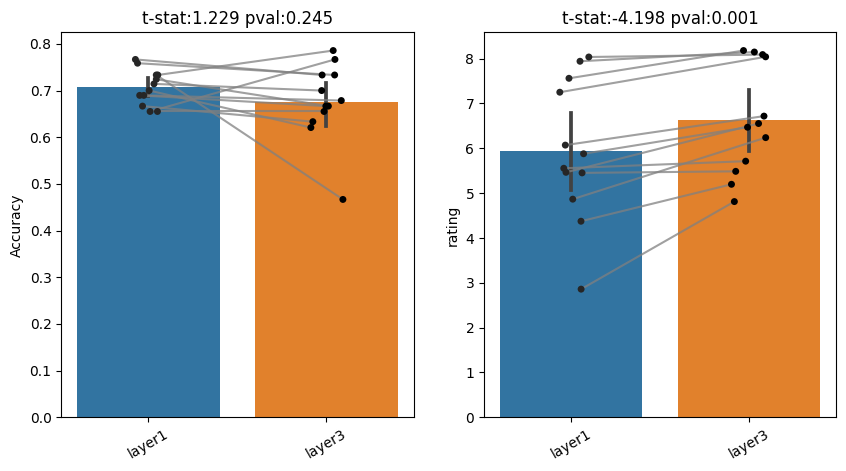

In [160]:
import scipy.stats as stats
import seaborn as sns


d1 = final_participants_df['level_1_accuracy']
d2 = final_participants_df['level_3_accuracy']
t_stat, p_value = stats.ttest_rel(d1, d2)


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['level_1_accuracy','level_3_accuracy']],ax=axes[0])
handel1 = sns.stripplot(data=final_participants_df[['level_1_accuracy','level_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')

sns.barplot(data=final_participants_df[['level_1_rating','level_3_rating']],ax = axes[1])
handel2 = sns.stripplot(data=final_participants_df[['level_1_rating','level_3_rating']],color='k',ax = axes[1])


d1 = final_participants_df['level_1_rating']
d2 = final_participants_df['level_3_rating']
t_stat, p_value = stats.ttest_rel(d1, d2)

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('rating')
axes[1].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')


add_connecting_lines_to_stripplot(handel1,axes[0])
add_connecting_lines_to_stripplot(handel2,axes[1])


Text(0, 0.5, 'RT')

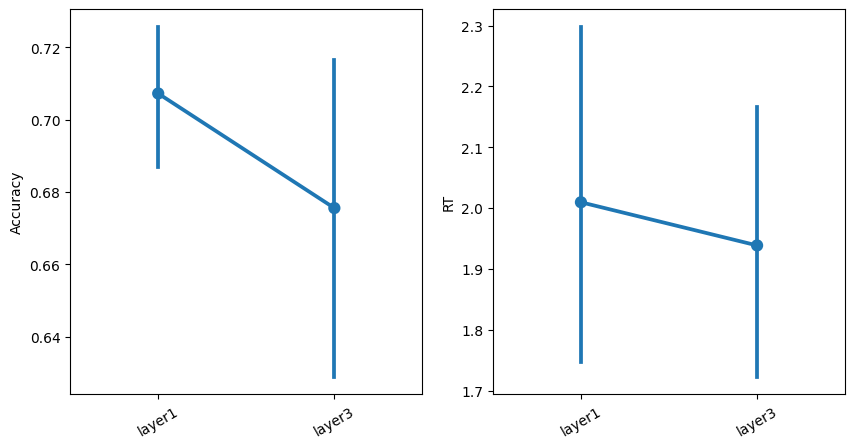

In [161]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['level_1_accuracy','level_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['level_1_rt','level_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('RT')


In [162]:
final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['level_1_rt','level_3_rt'],var_name='layer')
accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['level_1_accuracy','level_3_accuracy'],var_name='layer')

/var/folders/35/zj9lmn1x0ygd3qmyy6yx328w0000gn/T/ipykernel_87699/2052821063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


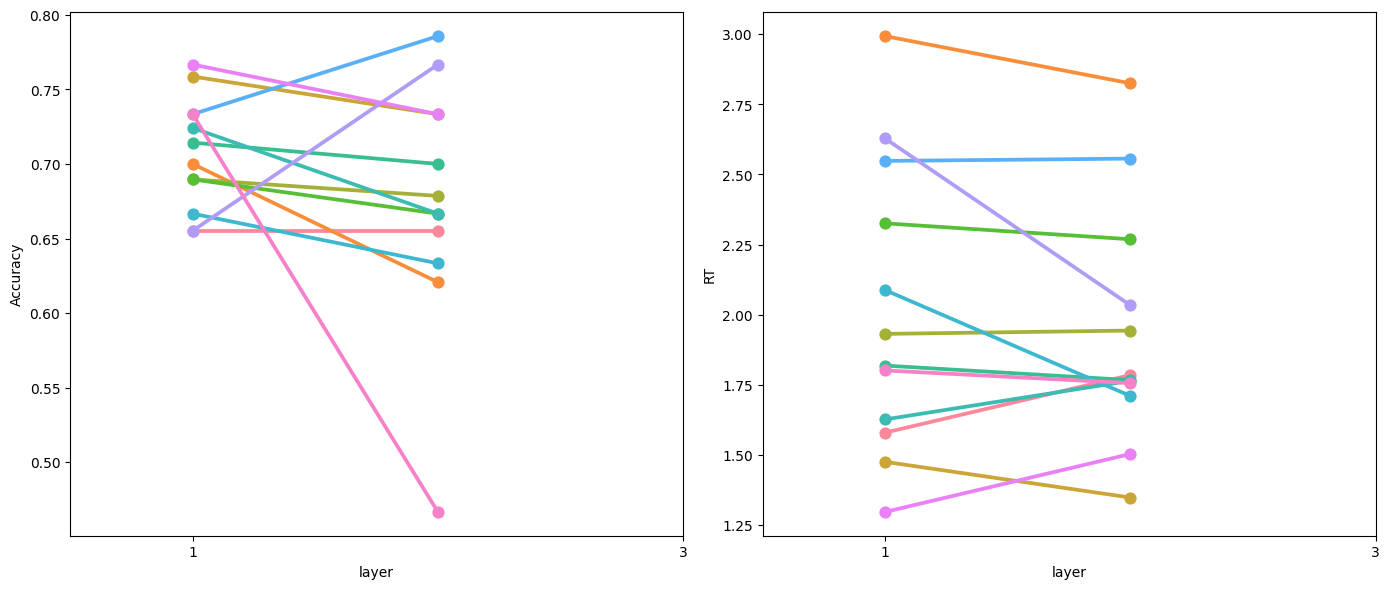

In [163]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,2],['1','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,2],['1','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

In [164]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 

import json
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict

{'A3CLHW8U4DXVI3': 11,
 'A1ODU7S7ENNY66': 16,
 'A24MNMHSFYW6B': 10,
 'A1SN7EOZUW5VP3': 3,
 'A3H2R42UQR0EPQ': 22,
 'A3DLP5ADP74EI0': 18,
 'AK84D0JFR31KS': 13,
 'AC4I7XU10MQXK': 7,
 'AH76Q73GSD7ET': 70,
 'A2M3DR0V45HNUL': 20,
 'A2VO8C41JJIQY9': 41,
 'AE0Q863L0ZKX6': 28,
 'A1GQWLAZQZP5VR': 56,
 'A2K3S7M6GPK5U': 25,
 'AFUODD7RP0JQO': 36,
 'A2E2Z8O95QL3IV': 44,
 'AS55GKL261S17': 47,
 'A3POFYGIXGWD3I': 54,
 'A3U5TFE0AWI2K9': 84,
 'A14NOAW77PC1ZN': 66,
 'A3QIWEQXAGMGD': 48,
 'A34EHWOYRBL6OZ': 14,
 'A3VWJQ8RNAPEO4': 63,
 'A8C3WNWRBWUXO': 65,
 'A1969Q0R4Y0E3J': 33,
 'A10JXOU89D5RXR': 79,
 'ALYR5CI2SM2JC': 40,
 'A1SUXLAA9QS64Y': 17,
 'A1ZFUHVIPQOVGK': 12,
 'A2AXPB2Y8VZ3MT': 0,
 'A31YCOB92SLSHL': 1,
 'A1GD9JRU44WE8P': 2,
 'AZQLST6FDM7ZS': 4,
 'A2JEPT85S2FRRN': 5,
 'AVF2Y89Z0W48N': 6,
 'A2QZYT2MINCCSC': 8,
 'A2818E670QPY2B': 9,
 'A198OUXVQWOI0': 15,
 'A2TXHID2H2TWMY': 19,
 'A2UTLTQY19TE21': 21,
 'AS0IF86V7OZOI': 23,
 'A3HOPYBWSR1TWR': 24,
 'A11246G6L1GMQB': 26,
 'A17ERTCKB0SN24': 27,
 'A3BDF09Y1UO

In [165]:
# upload qualifications csv
workers_df = pd.read_csv(PATH_TO_BATCH / 'Batch_workers.csv')

In [166]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    sub_id = sub_id.split('_')[0]
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
 

# append the final state of the last batch to the current batch for keeping all good participants 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent.parent / previous_batch
if target_dir in root_dirs:
    print(f'previous batch found:\n {target_dir} appending it to the shelf')
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)


83 were given a UPDATE-completed working memory test, names: ['A3CLHW8U4DXVI3', 'A1ODU7S7ENNY66', 'A24MNMHSFYW6B', 'A1SN7EOZUW5VP3', 'A3H2R42UQR0EPQ', 'A3DLP5ADP74EI0', 'AK84D0JFR31KS', 'AC4I7XU10MQXK', 'AH76Q73GSD7ET', 'A2M3DR0V45HNUL', 'A2VO8C41JJIQY9', 'AE0Q863L0ZKX6', 'A1GQWLAZQZP5VR', 'A2K3S7M6GPK5U', 'AFUODD7RP0JQO', 'A2E2Z8O95QL3IV', 'AS55GKL261S17', 'A3POFYGIXGWD3I', 'A3U5TFE0AWI2K9', 'A14NOAW77PC1ZN', 'A3QIWEQXAGMGD', 'A34EHWOYRBL6OZ', 'A3VWJQ8RNAPEO4', 'A8C3WNWRBWUXO', 'A1969Q0R4Y0E3J', 'A10JXOU89D5RXR', 'ALYR5CI2SM2JC', 'A1SUXLAA9QS64Y', 'A1ZFUHVIPQOVGK', 'A2AXPB2Y8VZ3MT', 'A31YCOB92SLSHL', 'A1GD9JRU44WE8P', 'AZQLST6FDM7ZS', 'A2JEPT85S2FRRN', 'AVF2Y89Z0W48N', 'A2QZYT2MINCCSC', 'A2818E670QPY2B', 'A198OUXVQWOI0', 'A2TXHID2H2TWMY', 'A2UTLTQY19TE21', 'AS0IF86V7OZOI', 'A3HOPYBWSR1TWR', 'A11246G6L1GMQB', 'A17ERTCKB0SN24', 'A3BDF09Y1UO4QL', 'A110TX2PKWIQ2O', 'A78BH291QSZ22', 'AWBTTY67HT1SX', 'AC7CDW53I98JT', 'A1EMG2T8QZBUHJ', 'A1OUN4CJ9TJFBS', 'A1SARRYNMZDVXB', 'A2D009L2PJ6641', 'A

'{"A2D009L2PJ6641": 42, "A3HOPYBWSR1TWR": 24, "A17ERTCKB0SN24": 27, "AKBDLLKJCG680": 46, "A2AXPB2Y8VZ3MT": 0, "A2JEPT85S2FRRN": 5, "A2QZYT2MINCCSC": 8, "A31YCOB92SLSHL": 1, "AOGUVIIJIXYO3": 71, "A11246G6L1GMQB": 26, "A1WD7UTKGWS016": 45, "AVF2Y89Z0W48N": 6}'

In [ ]:
simillarity_df = pd.DataFrame([])
for cat in ['badlands','bridge','golf_course','highway','mountain','playground']:
    filename = f'similarity_between_pairs_VGG{cat}.csv'
    PATH_TO_PROJECT = PATH_TO_BATCH.parent.parent.parent.parent
    cur_similarity_df = pd.read_csv(PATH_TO_PROJECT/filename)
    simillarity_df = pd.concat([simillarity_df,cur_similarity_df])


simillarity_df['image1'] = simillarity_df['image1'].str.replace('.pkl','.jpg')
simillarity_df['image2'] = simillarity_df['image2'].str.replace('.pkl','.jpg')

